# ECE 657A ASSIGNMENT 3
## Climate Fever Dataset

###### Jubilee Imhanzenobe and Olohireme Ajayi

In [1]:
# importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec, KeyedVectors
from datasets import load_dataset
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score

In [2]:
# downloading nltk.punkt
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

#### Defining relevant functions

In [3]:
def word_cloud_plot (data):
    """
    function that creates a word cloud from a specified column of a dataframe 
    """
    # create set of stopwords
    stopwords = set(STOPWORDS)

    # Instantiate the word cloud object
    word_cloud = WordCloud(background_color='white',max_words=200,stopwords=stopwords, width=800, height=400)
    
    # generate the word cloud
    word_cloud.generate(' '.join(data))
    
    # To display the word cloud
    plt.figure( figsize=(20,10) )
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [4]:
def regex_filter(sentence):
    """
    funtion that formats string to remove special characters
    """
    import re
    return re.sub('[^a-zA-Z]', ' ', sentence)

In [5]:
def filter_stop_words(token):
    """
    function that removes stopwords from a word-tokenized sentence
    """
    stop_words = set(stopwords.words('english'))
    filtered_token = [word.lower() for word in token if word.lower() not in stop_words]
    return filtered_token

In [6]:
def stem_words(token):
    """
    function that stems word-tokenized sentences
    """
    ps = PorterStemmer()
    stemmed_token = [ps.stem(word) for word in token]
    return stemmed_token

In [7]:
def lemmatize_words(token):
    """
    function that lemmatizes word-tokenized sentences
    """
    lem = WordNetLemmatizer()
    lemmatized_token = [lem.lemmatize(word, 'v') for word in token]
    return lemmatized_token

In [8]:
def join_token(token):
    """
    function that joins word-tokenized sentences back to single string
    """
    return ' '.join(token)

In [9]:
def get_embeddings(group, model):
    group_embedding = []
    group_labels = []
    
    unique_words = [word for sentence in group for word in sentence]
    unique_words = list(dict.fromkeys(unique_words))
    
    for word in unique_words:
        if model.wv.__contains__(word):
            group_embedding.append(list(model.wv.__getitem__(word)))
            group_labels.append(word)
            
    df_embedding = pd.DataFrame(group_embedding)
    df_word = pd.DataFrame(group_labels, columns = ["Word"])
    df = pd.concat([df_word, df_embedding], axis=1)
    return df

In [10]:
def similarity(words, stem_model=None, lem_model=None, W2V_pretrained=None, GloVe_pretrained=None):
    if stem_model:
        ps = PorterStemmer()
        stemmed = [ps.stem(word) for word in words]
        try:
            print("Stemmed W2V model similarity between", words[0], "and", words[1], "=", stem_model.wv.similarity(stemmed[0], stemmed[1]))
        except:
            print("Error: Word not in stem model vocabulary")
    
    if lem_model:
        lem = WordNetLemmatizer()
        lemma = [lem.lemmatize(word, 'v') for word in words]
        try:
            print("Lemmatized W2V model similarity between", words[0], "and", words[1], "=", lem_model.wv.similarity(lemma[0], lemma[1]))
        except:
            print("Error: Word not in lemmatized model vocabulary")        
    
    if W2V_pretrained:
        try:
            print("Word2vec pretrained model similarity between", words[0], "and", words[1], "=", W2V_pretrained.wv.similarity(words[0], words[1]))
        except:
            print("Error: Word not in Word2vec pretrained model vocabulary")
    
    if GloVe_pretrained:
        try:
            print("GloVe pretrained model similarity between", words[0], "and", words[1], "=", GloVe_pretrained.similarity(words[0], words[1]))
        except:
            print("Error: Word not in GloVe pretrained model vocabulary")    

In [11]:
def tsne_plot(df):
    """
    function that plots annotated scatter plot from a dataframe
    """
    plt.figure(figsize=(18, 18)) 
    for i in range(len(df)):
        plt.scatter(df.iloc[i,1],df.iloc[i,2])
        plt.annotate(df.iloc[i,0],
                     xy=(df.iloc[i,1], df.iloc[i,2]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [12]:
def get_sentence_embedding(data, column, train_word_embedding, test_word_embedding):
    data.reset_index(inplace=True, drop = True)
    sentence_embeddings = []
    for token in data[column]:
        embeddings = []
        for word in token:
            if word in train_word_embedding.index:
                embeddings.append(train_word_embedding.loc[word])
            else:
                embeddings.append(test_word_embedding.loc[word])
        
        embedding_array = np.array(embeddings)
        sentence_embedding = np.mean(embedding_array, axis=0)
        sentence_embeddings.append(list(sentence_embedding))
        
    features = len(sentence_embeddings[0])
    df = pd.DataFrame(sentence_embeddings, columns = ["feature_"+ str(i+1) for i in range(features)])
    df = pd.concat([data["claim"], df, data["claim_label"]], axis=1)
    return df   

In [13]:
def run_knn_opt(X_train, X_val, X_test, y_train, y_val, y_test, k_values):
    # Developing the Classification Model
    classifier = KNeighborsClassifier()
    classifier.fit(X_train,y_train)

    # Predicting the test set result
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)

    # Evaluating the Model
    cm = confusion_matrix(y_test,y_pred)

    accuracy_1 = round(100 * accuracy_score(y_test,y_pred), 2)
    f1_score_1 = round(f1_score(y_test, y_pred, average = "weighted"), 2)
    auc_1 = round(roc_auc_score(y_test, y_prob, average = "macro", multi_class = "ovo"), 2)

    y_pred_train  = classifier.predict(X_train)

    print("Training Set Evaluation")
    print("Accuracy: ", round(100 * accuracy_score(y_train, y_pred_train), 2))
    print("F1_score: ", round(f1_score(y_train, y_pred_train, average = 'weighted'), 2))
    print("AUC: ", round(roc_auc_score(y_train, classifier.predict_proba(X_train), average = "macro", multi_class = "ovo"), 2))
    print()
    print("Test Set Evaluation")
    print("Accuracy: ", accuracy_1)
    print("F1_score: ", f1_score_1)
    print("AUC: ", auc_1)
    
    accuracy = {}
    for k in k_values:
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train,y_train)

        # Predicting the test set result
        y_pred = classifier.predict(X_val)

        model_accuracy = accuracy_score(y_val, y_pred)

        accuracy[k] = round(model_accuracy * 100, 2)
        
    # plotting the parameter vs accuracy graph
    sns.lineplot(x = k_values, y = accuracy.values())

#### Downloading the dataset

In [14]:
dataset = load_dataset('climate_fever')

df = dataset['test'].to_pandas()
df2 = pd.json_normalize(dataset['test'], 'evidences', ['claim', 'claim_id','claim_label'], errors='ignore',record_prefix='Evidence_')

data1 = df[['claim', 'claim_label']]

Using custom data configuration default
Reusing dataset climate_fever (C:\Users\jubil\.cache\huggingface\datasets\climate_fever\default\1.0.1\3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


In [15]:
data1.head()

claim  claim_label
0  Global warming is driving polar bears toward e...            0
1  The sun has gone into ‘lockdown’ which could c...            0
2        The polar bear population has been growing.            1
3  Ironic' study finds more CO2 has slightly cool...            1
4  Human additions of CO2 are in the margin of er...            1

#### Histogram plot of claim labels and evidence labels

<AxesSubplot:xlabel='claim_label', ylabel='Count'>

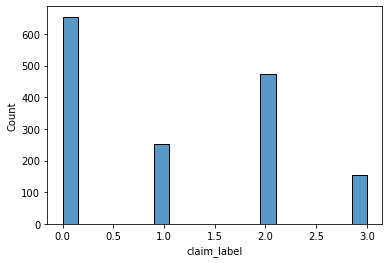

In [16]:
plt.figure()
sns.histplot(data = data1, x ='claim_label', bins = 20)

#### Word cloud of the claims in the dataset

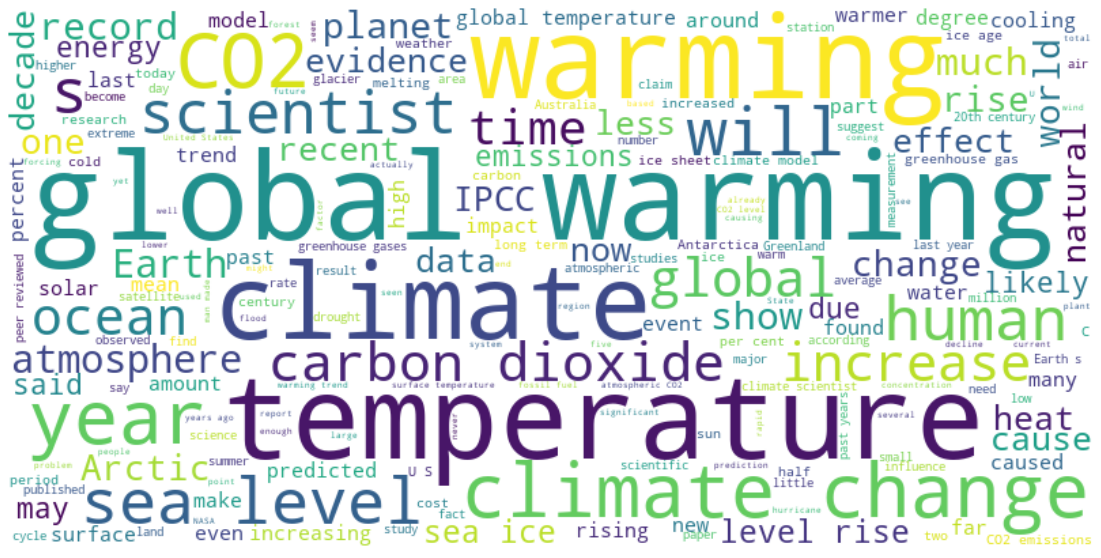

In [17]:
# visualizing word frequency in all claims
word_cloud_plot(data1['claim'])

#### Data preparation

In [18]:
# filter with regex
data1.loc[:, 'claim_token'] = data1.loc[:, 'claim'].apply(regex_filter)

# Tokenizing the claims
data1.loc[:, 'claim_token'] = data1.loc[:, 'claim_token'].apply(nltk.word_tokenize)

# Removing stop words from the claclaim_tokenim tokens
data1.loc[:,'claim_token'] = data1.loc[:,'claim_token'].apply(filter_stop_words)

# Stemming the words
data1.loc[:,'stemmed_words'] = data1.loc[:,'claim_token'].apply(stem_words)

# lemmatizing the words
data1.loc[:,'lemmatized_words'] = data1.loc[:,'claim_token'].apply(lemmatize_words)

C:\Users\jubil\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jubil\Anaconda3\lib\site-packages\pandas\core\indexing.py:1675: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
data1.head()

claim  claim_label  \
0  Global warming is driving polar bears toward e...            0   
1  The sun has gone into ‘lockdown’ which could c...            0   
2        The polar bear population has been growing.            1   
3  Ironic' study finds more CO2 has slightly cool...            1   
4  Human additions of CO2 are in the margin of er...            1   

                                         claim_token  \
0  [global, warming, driving, polar, bears, towar...   
1  [sun, gone, lockdown, could, cause, freezing, ...   
2                 [polar, bear, population, growing]   
3  [ironic, study, finds, co, slightly, cooled, p...   
4  [human, additions, co, margin, error, current,...   

                                       stemmed_words  \
0  [global, warm, drive, polar, bear, toward, ext...   
1  [sun, gone, lockdown, could, caus, freez, weat...   
2                         [polar, bear, popul, grow]   
3    [iron, studi, find, co, slightli, cool, planet]   
4  [human, addit, co, margin, error, current, mea...   

                                    lemmatized_words  
0  [global, warm, drive, polar, bear, toward, ext...  
1  [sun, go, lockdown, could, cause, freeze, weat...  
2                    [polar, bear, population, grow]  
3  [ironic, study, find, co, slightly, cool, planet]  
4  [human, additions, co, margin, error, current,...

#### Word cloud of the claims in the dataset (after data preparation)

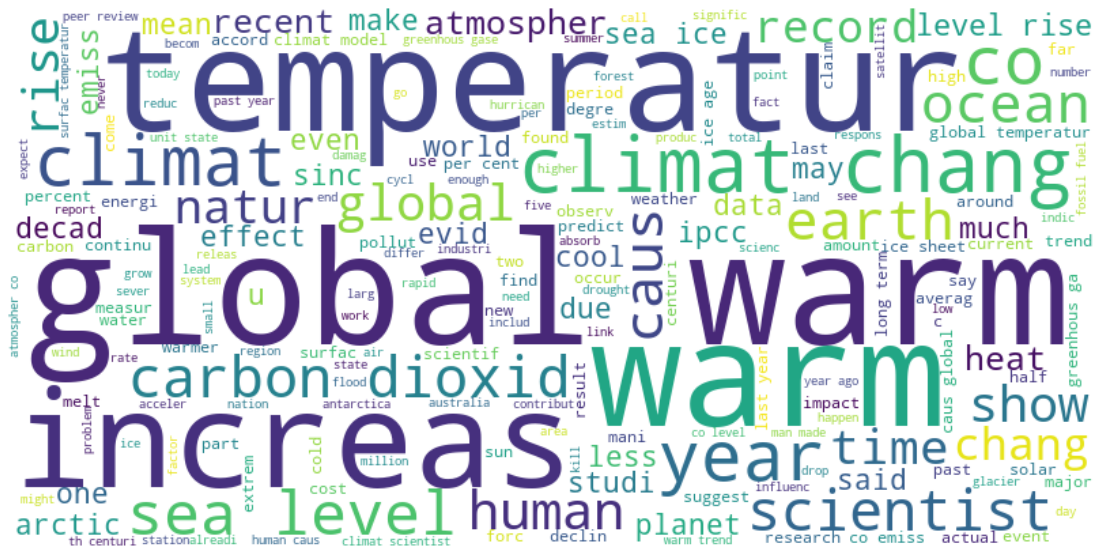

In [20]:
# Visualizing the word cloud again
word_cloud_plot(data1['stemmed_words'].apply(join_token))

#### Creating the corpus

In [21]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data1[['claim', 'stemmed_words', 'lemmatized_words', 'claim_label']], test_size=0.2, random_state=0)

In [22]:
train_data.shape

(1228, 4)

In [23]:
test_data.shape

(307, 4)

In [24]:
train_data.head()

claim  \
1247  When the PDO last switched to a cool phase, gl...   
184   as time progresses and fossil fuel emissions i...   
1026         Hurricanes aren't linked to global warming   
1522  Ljungqvist's millennial temperature reconstruc...   
1391  More importantly, the OISM list only contains ...   

                                          stemmed_words  \
1247  [pdo, last, switch, cool, phase, global, tempe...   
184   [time, progress, fossil, fuel, emiss, increas,...   
1026                     [hurrican, link, global, warm]   
1522  [ljungqvist, millenni, temperatur, reconstruct...   
1391  [importantli, oism, list, contain, scientist, ...   

                                       lemmatized_words  claim_label  
1247  [pdo, last, switch, cool, phase, global, tempe...            2  
184   [time, progress, fossil, fuel, emissions, incr...            2  
1026                   [hurricanes, link, global, warm]            2  
1522  [ljungqvist, millennial, temperature, reconstr...            2  
1391  [importantly, oism, list, contain, scientists,...            2

#### Training with the whole dataset

In [25]:
# creating the stemmed corpus and lemmatized corpus
corpus_stem = list(data1['stemmed_words'])
corpus_lem = list(data1['lemmatized_words'])

In [26]:
# getting the length of unique stemmed words
unique_set = [word for token in corpus_stem for word in token]
unique_set = set(unique_set)
len(unique_set)

2962

In [27]:
# getting the length of unique lemmatized words
unique_set2 = [word for token in corpus_lem for word in token]
unique_set2 = set(unique_set2)
len(unique_set2)

3324

#### Building the Word2Vec model

In [28]:
# Embeding with Word2Vec
model_stem = Word2Vec(corpus_stem, min_count=1)
model_lem = Word2Vec(corpus_lem, min_count=1)
print(model_stem)
print(model_lem)

Word2Vec(vocab=2962, size=100, alpha=0.025)
Word2Vec(vocab=3324, size=100, alpha=0.025)


In [29]:
words_list = [['man', 'bear'],['heat', 'warm'],['climate', 'weather'],['earth', 'global']]

In [30]:
for words in words_list:
    similarity(words = words, 
               stem_model = model_stem, 
               lem_model = model_lem
              )
    print()

Stemmed W2V model similarity between man and bear = 0.9791777
Lemmatized W2V model similarity between man and bear = 0.9538173

Stemmed W2V model similarity between heat and warm = 0.99810296
Lemmatized W2V model similarity between heat and warm = 0.99633855

Stemmed W2V model similarity between climate and weather = 0.9971125
Lemmatized W2V model similarity between climate and weather = 0.9941442

Stemmed W2V model similarity between earth and global = 0.99744046
Lemmatized W2V model similarity between earth and global = 0.99384016



#### Comparing with pretrained models

In [31]:
# Loading pretrained Word2Vec model
w2v_data = api.load("text8")
W2V_pretrained = Word2Vec(w2v_data)

In [32]:
# Loading pretrained GloVe model
GloVe_pretrained = api.load("glove-wiki-gigaword-50")

In [33]:
for words in words_list:
    similarity(words = words, 
               stem_model = model_stem, 
               lem_model = model_lem, 
               W2V_pretrained = W2V_pretrained, 
               GloVe_pretrained = GloVe_pretrained
              )
    print()

Stemmed W2V model similarity between man and bear = 0.9791777
Lemmatized W2V model similarity between man and bear = 0.9538173
Word2vec pretrained model similarity between man and bear = 0.36183244
GloVe pretrained model similarity between man and bear = 0.5815115

Stemmed W2V model similarity between heat and warm = 0.99810296
Lemmatized W2V model similarity between heat and warm = 0.99633855
Word2vec pretrained model similarity between heat and warm = 0.5202508
GloVe pretrained model similarity between heat and warm = 0.6819083

Stemmed W2V model similarity between climate and weather = 0.9971125
Lemmatized W2V model similarity between climate and weather = 0.9941442
Word2vec pretrained model similarity between climate and weather = 0.6200611
GloVe pretrained model similarity between climate and weather = 0.6746836

Stemmed W2V model similarity between earth and global = 0.99744046
Lemmatized W2V model similarity between earth and global = 0.99384016
Word2vec pretrained model similar

In [34]:
model_stem.wv['climat']

array([ 0.10668586, -0.0945586 ,  0.06419805, -0.08104347, -0.11044095,
       -0.11521757, -0.03854528, -0.1288418 , -0.16289692,  0.01939805,
       -0.15122709, -0.03586097, -0.01938155, -0.09839015,  0.13481766,
       -0.0055201 , -0.08705599,  0.13330808,  0.07184158, -0.06706462,
       -0.02412604,  0.10815147, -0.17361267, -0.03251623,  0.05363084,
       -0.00838957, -0.0549395 , -0.01133662, -0.13708732,  0.08962931,
       -0.07733145, -0.21076655, -0.04990598, -0.06071206, -0.03368278,
        0.03674287,  0.10840339,  0.02296602, -0.05270932,  0.07869124,
        0.00512313,  0.10290634, -0.09375903,  0.058876  , -0.1783555 ,
        0.06449103, -0.05802625,  0.13907315, -0.07628094, -0.0026361 ,
       -0.01274059, -0.1002916 , -0.01690309,  0.06633548, -0.05616571,
       -0.01363082,  0.09894381,  0.01319433,  0.02040597,  0.02626096,
        0.07184253, -0.01469532,  0.05904107, -0.01083329,  0.05059701,
       -0.03994681,  0.03953362,  0.02617535,  0.06314532, -0.09

In [35]:
len(model_stem.wv.vocab)

2962

In [36]:
train_embedding_stem = get_embeddings(list(train_data['stemmed_words']), model_stem)
train_embedding_stem.set_index("Word", inplace=True)
train_embedding_stem.head()

0         1         2         3         4         5         6   \
Word                                                                           
pdo     0.001390 -0.004469  0.008226 -0.001901 -0.008618 -0.005404 -0.001114   
last    0.044119 -0.042294  0.033959 -0.038216 -0.046488 -0.055195 -0.023694   
switch  0.000209 -0.005769  0.003992 -0.004222 -0.002853 -0.004724  0.001188   
cool    0.045840 -0.048212  0.027814 -0.040616 -0.046991 -0.055371 -0.021459   
phase   0.008718 -0.009693  0.009023 -0.008241 -0.009316 -0.009072 -0.003531   

              7         8         9   ...        90        91        92  \
Word                                  ...                                 
pdo    -0.009926 -0.013712 -0.003098  ... -0.006499  0.000114 -0.000904   
last   -0.057222 -0.081948  0.005779  ... -0.020143  0.018849 -0.014260   
switch -0.007854 -0.003619  0.005145  ... -0.007030  0.000126 -0.002182   
cool   -0.062652 -0.079232  0.006792  ... -0.025291  0.024397 -0.020976   
phase  -0.014441 -0.016066  0.001961  ... -0.003889  0.003630 -0.002240   

              93        94        95        96        97        98        99  
Word                                                                          
pdo    -0.004408  0.011920  0.002142 -0.006825 -0.001225 -0.004228 -0.001163  
last   -0.054466  0.071318 -0.024608 -0.030779 -0.018384 -0.009417 -0.011250  
switch -0.003971  0.011137 -0.006410 -0.004528  0.000142 -0.001644 -0.002664  
cool   -0.060821  0.073057 -0.018080 -0.035339 -0.023538 -0.016499 -0.017931  
phase  -0.008117  0.015637 -0.001926 -0.008400  0.000817 -0.003933 -0.007156  

[5 rows x 100 columns]

In [37]:
train_embedding_lem = get_embeddings(list(train_data['lemmatized_words']), model_lem)
train_embedding_lem.set_index("Word", inplace=True)
train_embedding_lem.head()

0         1         2         3         4         5         6   \
Word                                                                           
pdo    -0.004713 -0.000710  0.008656  0.001841 -0.001222 -0.001746  0.002100   
last   -0.000749 -0.017326  0.045444 -0.011216  0.011912 -0.034214  0.002521   
switch -0.003964 -0.003282  0.004170 -0.001462  0.002245 -0.002057  0.003374   
cool    0.000010 -0.022180  0.039863 -0.012923  0.013093 -0.033463  0.005358   
phase   0.001355 -0.006139  0.012108 -0.003873  0.000569 -0.006214  0.000965   

              7         8         9   ...        90        91        92  \
Word                                  ...                                 
pdo    -0.004153 -0.006565 -0.004958  ... -0.006975  0.002883 -0.002317   
last   -0.015776 -0.031770 -0.008794  ... -0.028977  0.049819 -0.033085   
switch -0.003693  0.001531  0.003822  ... -0.007178  0.001926 -0.003006   
cool   -0.020089 -0.027065 -0.009079  ... -0.034313  0.056189 -0.039737   
phase  -0.007849 -0.008462 -0.000976  ... -0.005837  0.010170 -0.006175   

              93        94        95        96        97        98        99  
Word                                                                          
pdo    -0.000428  0.007267  0.007063 -0.001963 -0.001671 -0.000266  0.004236  
last   -0.029472  0.043027  0.018080  0.007771 -0.026116  0.024870  0.036437  
switch -0.000984  0.007735 -0.002887 -0.001065 -0.000098  0.001140  0.000923  
cool   -0.034961  0.044309  0.026028  0.004457 -0.031385  0.018773  0.030549  
phase  -0.004853  0.011979  0.005782 -0.001795 -0.001124  0.002498  0.001468  

[5 rows x 100 columns]

#### Getting the test set embeddings

In [38]:
test_embedding_stem = get_embeddings(list(test_data['stemmed_words']), model_stem)
test_embedding_stem.set_index("Word", inplace=True)
test_embedding_stem.head()

0         1         2         3         4         5   \
Word                                                                    
trenberth  0.001427 -0.000841  0.006414  0.001166 -0.008784 -0.000169   
view       0.014043 -0.005999  0.004230 -0.009200 -0.006023 -0.006032   
clarifi    0.005339  0.001682  0.004657 -0.001989 -0.006296 -0.001606   
paper      0.026212 -0.020878  0.016627 -0.020527 -0.023819 -0.026474   
imper     -0.000589  0.000006  0.002317 -0.002149 -0.006479 -0.001620   

                 6         7         8         9   ...        90        91  \
Word                                               ...                       
trenberth  0.002189 -0.000458 -0.003105 -0.001011  ... -0.000311  0.002682   
view      -0.000561 -0.012598 -0.016788  0.001654  ... -0.004983  0.005483   
clarifi   -0.002886 -0.005195 -0.004337 -0.001444  ...  0.001927 -0.002418   
paper     -0.005729 -0.030302 -0.045305  0.007238  ... -0.016019  0.012025   
imper      0.001873 -0.004076 -0.005025  0.001596  ...  0.001959  0.003697   

                 92        93        94        95        96        97  \
Word                                                                    
trenberth -0.005948 -0.007701  0.002903 -0.004832 -0.005672  0.001260   
view       0.001075 -0.008699  0.009693 -0.001547 -0.011625 -0.008811   
clarifi   -0.002883 -0.002160  0.003808 -0.001751 -0.001384  0.001955   
paper     -0.005651 -0.035820  0.033952 -0.006253 -0.023065 -0.007631   
imper     -0.000515 -0.006589 -0.000315 -0.000759 -0.001110  0.004271   

                 98        99  
Word                           
trenberth  0.003442  0.001334  
view      -0.007170 -0.001573  
clarifi    0.004441  0.001046  
paper     -0.008445 -0.011422  
imper      0.000937  0.003567  

[5 rows x 100 columns]

In [39]:
test_embedding_lem = get_embeddings(list(test_data['lemmatized_words']), model_lem)
test_embedding_lem.set_index("Word", inplace=True)
test_embedding_lem.head()

0         1         2         3         4         5   \
Word                                                                     
trenberth  -0.002516  0.001598  0.006803  0.003621 -0.003807  0.002224   
view        0.004511  0.000573  0.003552 -0.003066  0.005566  0.000542   
clarify     0.002747 -0.003420 -0.000746  0.001644 -0.001718 -0.001298   
paper       0.001233 -0.006486  0.021040 -0.005372  0.007991 -0.013135   
imperative -0.003840  0.001922  0.002246 -0.001358 -0.002177  0.000492   

                  6         7         8         9   ...        90        91  \
Word                                                ...                       
trenberth   0.004280  0.003434  0.001699 -0.002251  ... -0.000626  0.004676   
view        0.004432 -0.002772 -0.004318 -0.000859  ... -0.004506  0.008298   
clarify     0.001077  0.002973  0.000437  0.001042  ...  0.003741  0.003851   
paper       0.007967 -0.006175 -0.016353 -0.000700  ... -0.019529  0.026731   
imperative  0.002096 -0.000383 -0.002532  0.001458  ... -0.000442  0.003973   

                  92        93        94        95        96        97  \
Word                                                                     
trenberth  -0.007036 -0.005156 -0.000129 -0.001440 -0.002441  0.001030   
view       -0.000259 -0.001188  0.000779  0.005305 -0.003973 -0.008664   
clarify     0.004241 -0.002533  0.000801  0.004968  0.004940  0.003832   
paper      -0.013937 -0.020544  0.016583  0.015885 -0.002321 -0.010812   
imperative -0.002316  0.003411  0.002686  0.000314 -0.003713  0.000824   

                  98        99  
Word                            
trenberth   0.006159  0.004903  
view       -0.001640  0.005822  
clarify     0.003433 -0.002420  
paper       0.009733  0.012609  
imperative  0.002349  0.000801  

[5 rows x 100 columns]

#### Getting Cosine similarity between all  words

In [40]:
cos_sim_w2v = cosine_similarity(test_embedding_stem.iloc[:,1:].values, Y=None, dense_output=True)

In [41]:
cos_sim_w2v.shape

(1291, 1291)

In [42]:
cos_sim_w2v = pd.DataFrame(cos_sim_w2v, columns = list(test_embedding_stem.index), index = list(test_embedding_stem.index))

In [43]:
cos_sim_w2v.head()

trenberth      view   clarifi     paper     imper    climat  \
trenberth   1.000000  0.647828  0.409637  0.704178  0.402730  0.710067   
view        0.647828  1.000000  0.304399  0.927709  0.394466  0.932825   
clarifi     0.409637  0.304399  1.000000  0.365838  0.308619  0.378571   
paper       0.704178  0.927709  0.365838  1.000000  0.404394  0.986631   
imper       0.402730  0.394466  0.308619  0.404394  1.000000  0.414083   

              chang      plan     track     earth  ...  tropospher    moreov  \
trenberth  0.717825  0.657902  0.669055  0.720400  ...    0.704320  0.615351   
view       0.931208  0.811437  0.882767  0.930345  ...    0.873024  0.794548   
clarifi    0.368675  0.351710  0.357951  0.375459  ...    0.367232  0.321852   
paper      0.984331  0.852022  0.940951  0.986027  ...    0.916456  0.812085   
imper      0.416700  0.326655  0.402045  0.403543  ...    0.372591  0.351592   

            coldest    donald      hoax   classic     feast    follow  \
trenberth  0.232959  0.310077  0.339256  0.085105  0.383940  0.681758   
view       0.370482  0.404041  0.436343  0.187098  0.329980  0.913107   
clarifi    0.180408 -0.054541  0.290859 -0.052236  0.203621  0.380484   
paper      0.387224  0.399709  0.487111  0.176603  0.318909  0.967534   
imper      0.149548  0.059968  0.232024  0.000596  0.092336  0.441434   

              coupl  recoveri  
trenberth  0.170357  0.418011  
view       0.358451  0.522053  
clarifi    0.114550  0.308012  
paper      0.391896  0.527275  
imper      0.038561  0.187507  

[5 rows x 1291 columns]

### Applying KNN on the Word2Vec Embeddings

In [44]:
knn_train_stem = train_data[['claim', 'stemmed_words', 'claim_label']]
knn_test_stem = test_data[['claim', 'stemmed_words', 'claim_label']]

In [45]:
knn_train_stem.head()

claim  \
1247  When the PDO last switched to a cool phase, gl...   
184   as time progresses and fossil fuel emissions i...   
1026         Hurricanes aren't linked to global warming   
1522  Ljungqvist's millennial temperature reconstruc...   
1391  More importantly, the OISM list only contains ...   

                                          stemmed_words  claim_label  
1247  [pdo, last, switch, cool, phase, global, tempe...            2  
184   [time, progress, fossil, fuel, emiss, increas,...            2  
1026                     [hurrican, link, global, warm]            2  
1522  [ljungqvist, millenni, temperatur, reconstruct...            2  
1391  [importantli, oism, list, contain, scientist, ...            2

In [46]:
knn_train_stem = get_sentence_embedding(knn_train_stem, 'stemmed_words', train_embedding_stem, test_embedding_stem)
knn_train_stem.shape

(1228, 102)

In [47]:
knn_train_stem.head()

claim  feature_1  feature_2  \
0  When the PDO last switched to a cool phase, gl...   0.039730  -0.035799   
1  as time progresses and fossil fuel emissions i...   0.050648  -0.043692   
2         Hurricanes aren't linked to global warming   0.065043  -0.057989   
3  Ljungqvist's millennial temperature reconstruc...   0.015863  -0.016370   
4  More importantly, the OISM list only contains ...   0.027754  -0.027165   

   feature_3  feature_4  feature_5  feature_6  feature_7  feature_8  \
0   0.026481  -0.031928  -0.042257  -0.045964  -0.015067  -0.051933   
1   0.032389  -0.036345  -0.050863  -0.052390  -0.019856  -0.060404   
2   0.039880  -0.048111  -0.067563  -0.072378  -0.023757  -0.081323   
3   0.011860  -0.013396  -0.017316  -0.018676  -0.005405  -0.021232   
4   0.019004  -0.022213  -0.031443  -0.031700  -0.010602  -0.036019   

   feature_9  ...  feature_92  feature_93  feature_94  feature_95  feature_96  \
0  -0.067485  ...    0.014837   -0.016124   -0.049444    0.062768   -0.016551   
1  -0.079150  ...    0.019589   -0.017498   -0.058164    0.071657   -0.020420   
2  -0.104815  ...    0.024167   -0.025321   -0.079353    0.096813   -0.028543   
3  -0.027656  ...    0.005724   -0.006836   -0.021245    0.025535   -0.005887   
4  -0.046394  ...    0.011220   -0.011202   -0.034948    0.044557   -0.010330   

   feature_97  feature_98  feature_99  feature_100  claim_label  
0   -0.030021   -0.015722   -0.012954    -0.013303            2  
1   -0.035035   -0.020293   -0.012523    -0.013146            2  
2   -0.048472   -0.021372   -0.018337    -0.017513            2  
3   -0.012350   -0.006725   -0.006425    -0.004179            2  
4   -0.021067   -0.011937   -0.006777    -0.007685            2  

[5 rows x 102 columns]

In [48]:
knn_test_stem = get_sentence_embedding(knn_test_stem, 'stemmed_words', train_embedding_stem, test_embedding_stem)
knn_test_stem.shape

(307, 102)

In [49]:
knn_test_stem.head()

claim  feature_1  feature_2  \
0  Trenberth's views are clarified in the paper "...   0.039765  -0.034719   
1  When life is considered, ocean acidification i...   0.023680  -0.021716   
2  In recent decades this warming has been accomp...   0.049158  -0.042638   
3  while it’s true that studies in some regions s...   0.029851  -0.028242   
4  It is unclear whether global warming is increa...   0.054971  -0.050004   

   feature_3  feature_4  feature_5  feature_6  feature_7  feature_8  \
0   0.025481  -0.029367  -0.041518  -0.041829  -0.013982  -0.047903   
1   0.014510  -0.018461  -0.025727  -0.028160  -0.009696  -0.030683   
2   0.029576  -0.035764  -0.049777  -0.052882  -0.018723  -0.059273   
3   0.020253  -0.023339  -0.032185  -0.034963  -0.012643  -0.038756   
4   0.034448  -0.040565  -0.057190  -0.060851  -0.020826  -0.067295   

   feature_9  ...  feature_92  feature_93  feature_94  feature_95  feature_96  \
0  -0.063370  ...    0.014901   -0.013916   -0.048448    0.056614   -0.015536   
1  -0.041616  ...    0.009151   -0.009989   -0.029715    0.037804   -0.010068   
2  -0.078490  ...    0.019745   -0.018684   -0.058920    0.071279   -0.019718   
3  -0.051598  ...    0.011612   -0.012451   -0.036576    0.045426   -0.013192   
4  -0.089716  ...    0.020819   -0.020407   -0.067510    0.081709   -0.023404   

   feature_97  feature_98  feature_99  feature_100  claim_label  
0   -0.028364   -0.013937   -0.010041    -0.010326            0  
1   -0.018204   -0.008985   -0.006391    -0.006489            1  
2   -0.034505   -0.018441   -0.011628    -0.013514            0  
3   -0.022691   -0.012336   -0.006608    -0.008889            1  
4   -0.039818   -0.019385   -0.016067    -0.015066            0  

[5 rows x 102 columns]

In [50]:
X_train = knn_train_stem.iloc[:,1:-1].values
y_train = knn_train_stem.iloc[:,-1].values
X_test = knn_test_stem.iloc[:,1:-1].values
y_test = knn_test_stem.iloc[:,-1].values

In [51]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

Training Set Evaluation
Accuracy:  56.92
F1_score:  0.53
AUC:  0.83

Test Set Evaluation
Accuracy:  40.26
F1_score:  0.36
AUC:  0.47


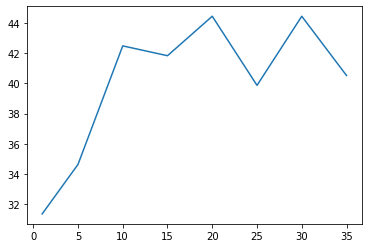

In [52]:
run_knn_opt(X_train, X_val, X_test, y_train, y_val, y_test, [1,5,10,15,20,25,30,35])

In [53]:
k_opt = 20

classifier = KNeighborsClassifier(n_neighbors = k_opt)
classifier.fit(X_train,y_train)

# Predicting the test set result
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)

# Evaluating the model
accuracy_2 = round(100 * accuracy_score(y_test, y_pred), 2)
f1_score_2 = round(f1_score(y_test, y_pred, average = "weighted"), 2)
auc_2 = round(roc_auc_score(y_test, y_prob, average = "macro", multi_class = "ovo"), 2)

print("Test Set Evaluation")
print("Accuracy: ", accuracy_2)
print("F1_score: ", f1_score_2)
print("AUC: ", auc_2)
print()
print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, classifier.predict(X_train)), 2))
print("F1_score: ", round(f1_score(y_train, classifier.predict(X_train), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_train, classifier.predict_proba(X_train), average = "macro", multi_class = "ovo"), 2))
print()
print("Validation Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_val, classifier.predict(X_val)), 2))
print("F1_score: ", round(f1_score(y_val, classifier.predict(X_val), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_val, classifier.predict_proba(X_val), average = "macro", multi_class = "ovo"), 2))

Test Set Evaluation
Accuracy:  44.16
F1_score:  0.36
AUC:  0.5

Training Set Evaluation
Accuracy:  48.05
F1_score:  0.42
AUC:  0.69

Validation Set Evaluation
Accuracy:  44.44
F1_score:  0.39
AUC:  0.49


## PCA

### Using Stemming

In [54]:
from sklearn.decomposition import PCA
n_components = 30
pca = PCA(n_components=n_components)
pca.fit_transform(train_embedding_stem.iloc[:,:].values)
explained_variance = pca.explained_variance_ratio_

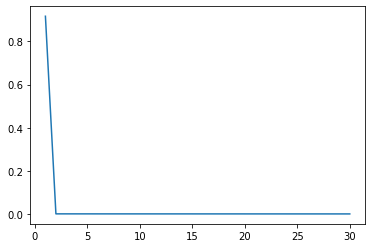

In [55]:
plt.plot(range(1, n_components + 1), explained_variance)

In [56]:
# Building optimal PCA model
columns = ['PC_1','PC_2','PC_3','PC_4','PC_5']
pca = PCA(n_components=5)
pca_train = pca.fit_transform(train_embedding_stem.iloc[:,:].values)
pca_train = pd.DataFrame(pca_train, columns = columns)
pca_train.index = train_embedding_stem.index
pca_train.head()

PC_1      PC_2      PC_3      PC_4      PC_5
Word                                                    
pdo    -0.008859  0.002174 -0.001547 -0.002020 -0.000168
last    0.309605 -0.004258  0.003669 -0.002757  0.004448
switch -0.025034 -0.000023  0.003094  0.004725 -0.000926
cool    0.319112  0.003532  0.002353 -0.004583  0.001752
phase   0.007864  0.005780 -0.003048 -0.002748  0.003548

In [57]:
pca_test = pca.transform(test_embedding_stem.iloc[:,:].values)
pca_test = pd.DataFrame(pca_test, columns = columns)
pca_test.index = test_embedding_stem.index
pca_test.head()

PC_1      PC_2      PC_3      PC_4      PC_5
Word                                                       
trenberth -0.026367  0.005566 -0.000616  0.001018  0.001192
view       0.023539  0.002334 -0.005957 -0.005515  0.001011
clarifi   -0.042806 -0.003934  0.004392  0.004581 -0.003071
paper      0.138155  0.001729 -0.004384 -0.002830  0.001821
imper     -0.042402  0.000751 -0.001741 -0.000646 -0.000541

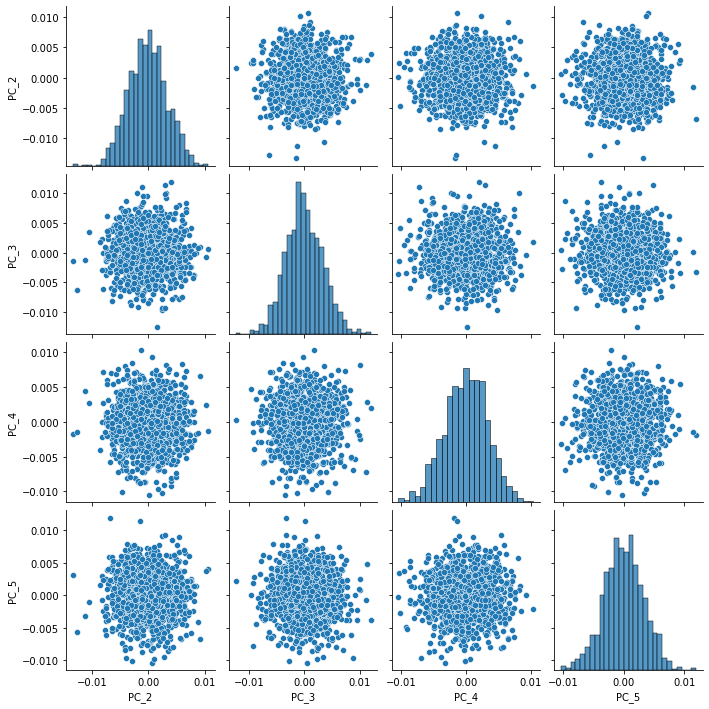

In [58]:
sns.pairplot(pca_test.iloc[:,1:5])

### Using Lemmatization

In [59]:
pca = PCA(n_components=30)
pca.fit_transform(train_embedding_lem.iloc[:,:].values)
explained_variance = pca.explained_variance_ratio_

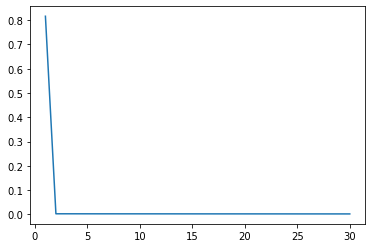

In [60]:
plt.plot(range(1, n_components + 1), explained_variance)

In [61]:
# Building optimal PCA model
pca = PCA(n_components=5)
pca_train_lem = pca.fit_transform(train_embedding_lem.iloc[:,:].values)
pca_train_lem = pd.DataFrame(pca_train_lem, columns = columns)
pca_train_lem.index = train_embedding_lem.index
pca_train_lem.head()

PC_1      PC_2      PC_3      PC_4      PC_5
Word                                                    
pdo    -0.009512 -0.003395  0.001201 -0.001182 -0.007687
last    0.235764  0.006836 -0.001921  0.001030  0.001373
switch -0.014548 -0.000448 -0.001414 -0.003967 -0.002218
cool    0.242343 -0.002299 -0.001268 -0.000182  0.000385
phase   0.022563  0.000528  0.003717  0.000258  0.000296

In [62]:
pca_test_lem = pca.transform(test_embedding_lem.iloc[:,:].values)
pca_test_lem = pd.DataFrame(pca_test_lem, columns = columns)
pca_test_lem.index = test_embedding_lem.index
pca_test_lem.head()

PC_1      PC_2      PC_3      PC_4      PC_5
Word                                                        
trenberth  -0.013326 -0.005253  0.000270 -0.001491 -0.001575
view        0.005510  0.001696  0.002615 -0.006110  0.001904
clarify    -0.028411  0.003180 -0.003418  0.002256  0.001983
paper       0.095612 -0.003578  0.008211 -0.000422  0.002151
imperative -0.025972  0.001936 -0.003150  0.001581  0.000456

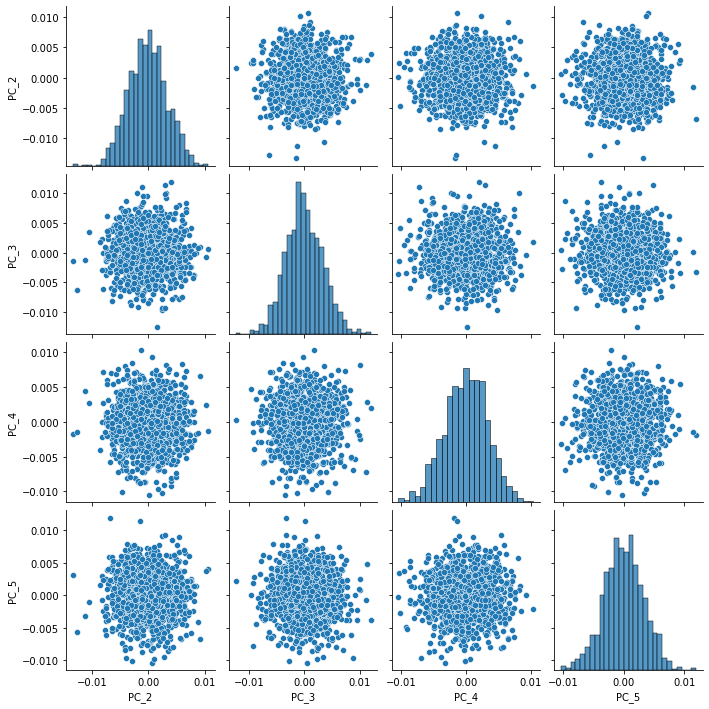

In [63]:
sns.pairplot(pca_test.iloc[:,1:5])

#### Getting Cosine similarity between all  words

In [64]:
cos_sim_pca = cosine_similarity(pca_test.iloc[:,:].values, Y=None, dense_output=False)

In [65]:
cos_sim_pca.shape

(1291, 1291)

In [66]:
cos_sim_pca = pd.DataFrame(cos_sim_pca, columns = list(pca_test.index), index = list(pca_test.index))
cos_sim_pca

trenberth      view   clarifi     paper     imper    climat  \
trenberth   1.000000 -0.900264  0.939548 -0.972562  0.978809 -0.975572   
view       -0.900264  1.000000 -0.982609  0.953393 -0.925092  0.939441   
clarifi     0.939548 -0.982609  1.000000 -0.989219  0.975066 -0.981736   
paper      -0.972562  0.953393 -0.989219  1.000000 -0.996263  0.998872   
imper       0.978809 -0.925092  0.975066 -0.996263  1.000000 -0.998456   
...              ...       ...       ...       ...       ...       ...   
classic     0.981340 -0.916369  0.958772 -0.987923  0.989095 -0.991692   
feast       0.987455 -0.901318  0.947396 -0.974769  0.980105 -0.975251   
follow     -0.974354  0.950188 -0.988544  0.998704 -0.996753  0.997144   
coupl       0.962352 -0.964616  0.989554 -0.996135  0.986512 -0.993676   
recoveri    0.942227 -0.901937  0.958743 -0.980601  0.982200 -0.983375   

              chang      plan     track     earth  ...  tropospher    moreov  \
trenberth -0.975697  0.690879 -0.970529 -0.975783  ...   -0.842561  0.923439   
view       0.945583 -0.561909  0.892534  0.941740  ...    0.958740 -0.814838   
clarifi   -0.984817  0.617660 -0.957225 -0.983267  ...   -0.950866  0.881348   
paper      0.999407 -0.628889  0.984611  0.999204  ...    0.923585 -0.908116   
imper     -0.997865  0.657156 -0.994436 -0.998543  ...   -0.892193  0.928658   
...             ...       ...       ...       ...  ...         ...       ...   
classic   -0.989484  0.571120 -0.979779 -0.990303  ...   -0.902474  0.878904   
feast     -0.974158  0.683028 -0.983300 -0.975512  ...   -0.875487  0.901570   
follow     0.998177 -0.666428  0.987529  0.998009  ...    0.912275 -0.924108   
coupl     -0.994138  0.567125 -0.969577 -0.993496  ...   -0.947131  0.870630   
recoveri  -0.979560  0.541146 -0.984113 -0.981841  ...   -0.923080  0.854511   

            coldest    donald      hoax   classic     feast    follow  \
trenberth  0.952135  0.959279  0.978541  0.981340  0.987455 -0.974354   
view      -0.943443 -0.874120 -0.931486 -0.916369 -0.901318  0.950188   
clarifi    0.987930  0.946554  0.978157  0.958772  0.947396 -0.988544   
paper     -0.995712 -0.978819 -0.997590 -0.987923 -0.974769  0.998704   
imper      0.993419  0.991453  0.999778  0.989095  0.980105 -0.996753   
...             ...       ...       ...       ...       ...       ...   
classic    0.976357  0.976725  0.989798  1.000000  0.979321 -0.982445   
feast      0.960101  0.967184  0.978357  0.979321  1.000000 -0.977762   
follow    -0.995177 -0.980071 -0.997487 -0.982445 -0.977762  1.000000   
coupl      0.989250  0.963304  0.989223  0.987629  0.964560 -0.990977   
recoveri   0.983483  0.983752  0.981446  0.982726  0.964204 -0.975681   

              coupl  recoveri  
trenberth  0.962352  0.942227  
view      -0.964616 -0.901937  
clarifi    0.989554  0.958743  
paper     -0.996135 -0.980601  
imper      0.986512  0.982200  
...             ...       ...  
classic    0.987629  0.982726  
feast      0.964560  0.964204  
follow    -0.990977 -0.975681  
coupl      1.000000  0.978854  
recoveri   0.978854  1.000000  

[1291 rows x 1291 columns]

In [67]:
cos_sim_pca["view"]["clarifi"]

-0.9826089270045597

### Applying KNN on the PCA Embeddings

In [68]:
knn_train_stem = train_data[['claim', 'stemmed_words', 'claim_label']]
knn_test_stem = test_data[['claim', 'stemmed_words', 'claim_label']]

In [69]:
knn_train_stem.head()

claim  \
1247  When the PDO last switched to a cool phase, gl...   
184   as time progresses and fossil fuel emissions i...   
1026         Hurricanes aren't linked to global warming   
1522  Ljungqvist's millennial temperature reconstruc...   
1391  More importantly, the OISM list only contains ...   

                                          stemmed_words  claim_label  
1247  [pdo, last, switch, cool, phase, global, tempe...            2  
184   [time, progress, fossil, fuel, emiss, increas,...            2  
1026                     [hurrican, link, global, warm]            2  
1522  [ljungqvist, millenni, temperatur, reconstruct...            2  
1391  [importantli, oism, list, contain, scientist, ...            2

In [70]:
knn_train_stem = get_sentence_embedding(knn_train_stem, 'stemmed_words', pca_train, pca_test)
knn_train_stem.shape

(1228, 7)

In [71]:
knn_train_stem.head()

claim  feature_1  feature_2  \
0  When the PDO last switched to a cool phase, gl...   0.255765  -0.000594   
1  as time progresses and fossil fuel emissions i...   0.311386   0.000649   
2         Hurricanes aren't linked to global warming   0.434741  -0.000512   
3  Ljungqvist's millennial temperature reconstruc...   0.075485   0.001718   
4  More importantly, the OISM list only contains ...   0.162085   0.000602   

   feature_3  feature_4  feature_5  claim_label  
0  -0.000996   0.000546   0.002823            2  
1   0.000627   0.000126  -0.000578            2  
2  -0.002492   0.003036  -0.000117            2  
3  -0.000149  -0.000728   0.000752            2  
4   0.002604   0.000515  -0.002547            2

In [72]:
knn_test_stem = get_sentence_embedding(knn_test_stem, 'stemmed_words', pca_train, pca_test)
knn_test_stem.shape

(307, 7)

In [73]:
knn_test_stem.head()

claim  feature_1  feature_2  \
0  Trenberth's views are clarified in the paper "...   0.240950   0.001427   
1  When life is considered, ocean acidification i...   0.131769   0.001188   
2  In recent decades this warming has been accomp...   0.310982   0.001013   
3  while it’s true that studies in some regions s...   0.180306   0.000271   
4  It is unclear whether global warming is increa...   0.358256  -0.001027   

   feature_3  feature_4  feature_5  claim_label  
0  -0.002012   0.000227  -0.000913            0  
1   0.000641   0.000757   0.000780            1  
2  -0.000383  -0.001413  -0.000299            0  
3   0.000731  -0.000169  -0.000156            1  
4  -0.000447   0.000107  -0.001572            0

In [74]:
X_train = knn_train_stem.iloc[:,1:-1].values
y_train = knn_train_stem.iloc[:,-1].values
X_test = knn_test_stem.iloc[:,1:-1].values
y_test = knn_test_stem.iloc[:,-1].values

In [75]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

Training Set Evaluation
Accuracy:  53.99
F1_score:  0.51
AUC:  0.81

Test Set Evaluation
Accuracy:  37.01
F1_score:  0.31
AUC:  0.48


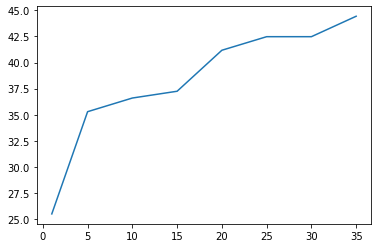

In [76]:
run_knn_opt(X_train, X_val, X_test, y_train, y_val, y_test, [1,5,10,15,20,25,30,35])

In [77]:
k_opt = 30

classifier = KNeighborsClassifier(n_neighbors = k_opt)
classifier.fit(X_train,y_train)

# Predicting the test set result
y_pred = classifier.predict(X_test)
y_prob = classifier.predict_proba(X_test)

# Evaluating the model
accuracy_2 = round(100 * accuracy_score(y_test, y_pred), 2)
f1_score_2 = round(f1_score(y_test, y_pred, average = "weighted"), 2)
auc_2 = round(roc_auc_score(y_test, y_prob, average = "macro", multi_class = "ovo"), 2)

print("Test Set Evaluation")
print("Accuracy: ", accuracy_2)
print("F1_score: ", f1_score_2)
print("AUC: ", auc_2)
print()
print("Training Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_train, classifier.predict(X_train)), 2))
print("F1_score: ", round(f1_score(y_train, classifier.predict(X_train), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_train, classifier.predict_proba(X_train), average = "macro", multi_class = "ovo"), 2))
print()
print("Validation Set Evaluation")
print("Accuracy: ", round(100 * accuracy_score(y_val, classifier.predict(X_val)), 2))
print("F1_score: ", round(f1_score(y_val, classifier.predict(X_val), average = 'weighted'), 2))
print("AUC: ", round(roc_auc_score(y_val, classifier.predict_proba(X_val), average = "macro", multi_class = "ovo"), 2))

Test Set Evaluation
Accuracy:  41.56
F1_score:  0.35
AUC:  0.53

Training Set Evaluation
Accuracy:  46.34
F1_score:  0.39
AUC:  0.67

Validation Set Evaluation
Accuracy:  42.48
F1_score:  0.37
AUC:  0.51


## LLE

### Using Stemming

In [78]:
from sklearn.manifold import LocallyLinearEmbedding

In [79]:
n_components = [1, 2, 3, 5, 7, 10, 20, 30]
reconstruction_error = []
for n in n_components:
    lle_model = LocallyLinearEmbedding(n_components=n, random_state=0)
    lle_vectors = lle_model.fit_transform(test_embedding_stem.iloc[:,:].values)
    reconstruction_error.append(lle_model.reconstruction_error_)

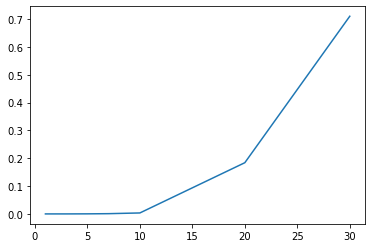

In [80]:
plt.plot(n_components, reconstruction_error)

In [81]:
lle_model = LocallyLinearEmbedding(n_components=4, random_state=0)
lle_vectors = lle_model.fit_transform(test_embedding_stem.iloc[:,:].values)

df_lle = pd.DataFrame(lle_vectors, columns = ["feature1", "feature2", "feature3", "feature4"])
df_lle.index = test_embedding_stem.index

In [82]:
df_lle.head()

feature1  feature2  feature3  feature4
Word                                             
trenberth  0.007667  0.011305 -0.001565  0.011379
view       0.007643  0.009495 -0.000898  0.000709
clarifi    0.007669  0.011468 -0.001643  0.013041
paper      0.006598 -0.051767  0.012467 -0.050196
imper      0.007669  0.011489 -0.001649  0.013241

In [83]:
lle_model.reconstruction_error_

5.606575593941972e-05

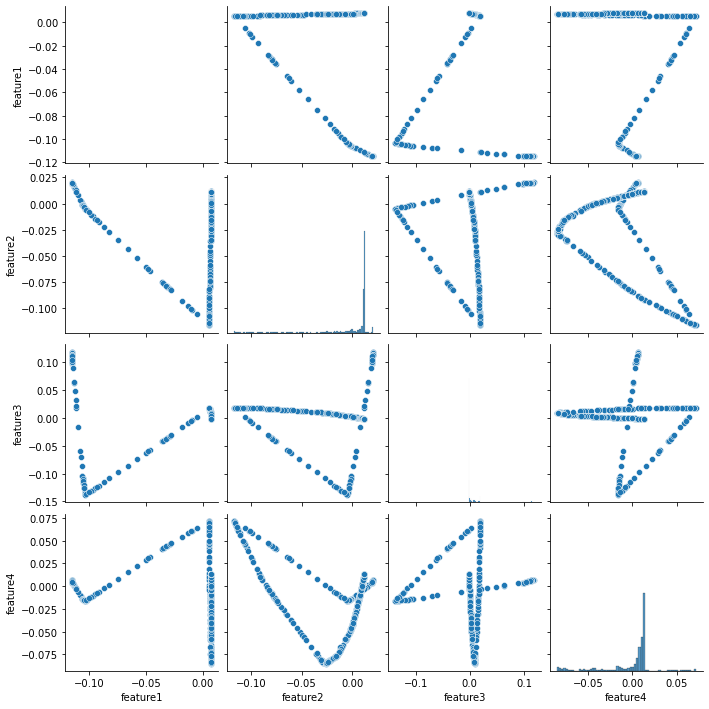

In [84]:
sns.pairplot(df_lle.iloc[:,0:4])

### Using Lemmatization

In [85]:
n_components = [1, 2, 3, 5, 7, 10, 20, 30]
reconstruction_error = []
for n in n_components:
    lle_model = LocallyLinearEmbedding(n_components=n, random_state=0)
    lle_vectors = lle_model.fit_transform(test_embedding_lem.iloc[:,:].values)
    reconstruction_error.append(lle_model.reconstruction_error_)

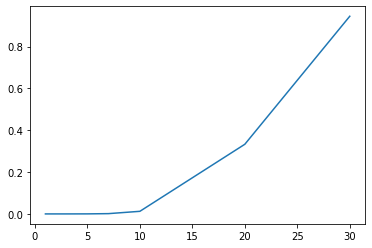

In [86]:
plt.plot(n_components, reconstruction_error)

In [87]:
lle_model = LocallyLinearEmbedding(n_components=4, random_state=0)
lle_vectors = lle_model.fit_transform(test_embedding_lem.iloc[:,1:].values)

df_lle = pd.DataFrame(lle_vectors, columns = ["feature1", "feature2", "feature3", "feature4"])
df_lle.index = test_embedding_lem.index

In [88]:
df_lle.head()

feature1  feature2  feature3  feature4
Word                                              
trenberth   0.007283 -0.004165  0.001143  0.013236
view        0.007275 -0.019502  0.001096  0.009932
clarify     0.007284 -0.009138  0.001185  0.013938
paper       0.006548 -0.003713 -0.002206 -0.060723
imperative  0.007284  0.007373  0.001133  0.014444

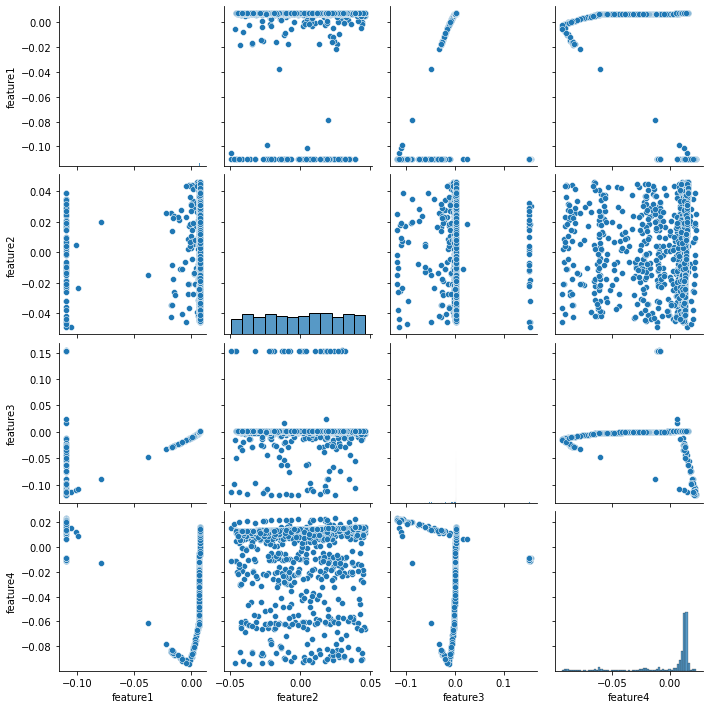

In [89]:
sns.pairplot(df_lle.iloc[:,:])

In [90]:
lle_model.reconstruction_error_

3.11557949076893e-05

#### Getting Cosine similarity between all  words

In [91]:
cos_sim_lle = cosine_similarity(df_lle.iloc[:,1:].values, Y=None, dense_output=False)

In [92]:
cos_sim_lle.shape

(1364, 1364)

In [93]:
cos_sim_lle = pd.DataFrame(cos_sim_lle, columns = list(df_lle.index), index = list(df_lle.index))
cos_sim_lle

trenberth      view   clarify     paper  imperative   climate  \
trenberth    1.000000  0.701225  0.962459 -0.933003    0.714707  0.051149   
view         0.701225  1.000000  0.868376 -0.399627    0.002530  0.124157   
clarify      0.962459  0.868376  1.000000 -0.801290    0.498052  0.077640   
paper       -0.933003 -0.399627 -0.801290  1.000000   -0.916449  0.040358   
imperative   0.714707  0.002530  0.498052 -0.916449    1.000000 -0.046430   
...               ...       ...       ...       ...         ...       ...   
feast        0.828831  0.980056  0.949575 -0.573804    0.201054  0.104825   
river        0.781121  0.992870  0.921261 -0.506047    0.121570  0.111904   
follow      -0.438387  0.332735 -0.178473  0.731461   -0.941171  0.128470   
couple       0.331666 -0.439995  0.063170 -0.646059    0.896877 -0.093132   
recovery     0.999773  0.686033  0.956534 -0.940453    0.729282  0.045593   

              change      plan     track     earth  ...  moreover   coldest  \
trenberth   0.019600  0.489394  0.437166  0.136451  ...  0.977904  0.073045   
view        0.016894  0.964903  0.947755 -0.010417  ...  0.834764 -0.659792   
clarify     0.014821  0.707686  0.664833  0.096077  ...  0.997909 -0.200382   
paper       0.027534 -0.145227 -0.086746 -0.223799  ... -0.837626 -0.423973   
imperative  0.014578 -0.260165 -0.316599  0.198024  ...  0.552718  0.749759   
...              ...       ...       ...       ...  ...       ...       ...   
feast       0.011805  0.893516  0.865512  0.036607  ...  0.927450 -0.497457   
river       0.012652  0.926761  0.903021  0.018974  ...  0.894364 -0.565654   
follow      0.035427  0.568413  0.615833 -0.232679  ... -0.240910 -0.927170   
couple      0.009121 -0.660374 -0.703467  0.178999  ...  0.127152  0.965103   
recovery    0.016543  0.470899  0.418108  0.142457  ...  0.973268  0.094034   

              donald      hoax   classic     feast     river    follow  \
trenberth   0.074358  0.531956  0.724485  0.828831  0.781121 -0.438387   
view       -0.658802 -0.230660  0.999418  0.980056  0.992870  0.332735   
clarify    -0.199092  0.282164  0.884373  0.949575  0.921261 -0.178473   
paper      -0.425161 -0.798442 -0.430138 -0.573804 -0.506047  0.731461   
imperative  0.750629  0.972444  0.035697  0.201054  0.121570 -0.941171   
...              ...       ...       ...       ...       ...       ...   
feast      -0.496315 -0.032862  0.986133  1.000000  0.996755  0.138706   
river      -0.564568 -0.113185  0.996288  0.996755  1.000000  0.217953   
follow     -0.927657 -0.993238  0.300949  0.138706  0.217953  1.000000   
couple      0.965447  0.975274 -0.409982 -0.252927 -0.329965 -0.992174   
recovery    0.095344  0.549671  0.709810  0.816867  0.767795 -0.457340   

              couple  recovery  
trenberth   0.331666  0.999773  
view       -0.439995  0.686033  
clarify     0.063170  0.956534  
paper      -0.646059 -0.940453  
imperative  0.896877  0.729282  
...              ...       ...  
feast      -0.252927  0.816867  
river      -0.329965  0.767795  
follow     -0.992174 -0.457340  
couple      1.000000  0.351463  
recovery    0.351463  1.000000  

[1364 rows x 1364 columns]

## TSNE

### Using Stemming

In [94]:
from sklearn.manifold import TSNE

In [95]:
tsne_model = TSNE(n_components=2, init='pca', random_state=0)
tsne_vectors = tsne_model.fit_transform(test_embedding_stem.iloc[:,:].values)

In [96]:
df_tsne = pd.DataFrame(tsne_vectors, columns = ["feature1", "feature2"])
df_tsne.index = test_embedding_stem.index

In [97]:
df_tsne.head()

feature1  feature2
Word                          
trenberth -21.945560 -4.375201
view       16.259203 -7.358448
clarifi   -38.279202 -3.367740
paper      52.830780  1.846657
imper     -34.834206 -6.012908

In [98]:
fig = px.scatter(df_tsne, x="feature1", y="feature2",
                 hover_name=list(df_tsne.index))
fig.show("notebook")

In [99]:
tsne_model.kl_divergence_

1.427573323249817

In [100]:
tsne_model.n_iter_

999

### Using Lemmatization

In [101]:
tsne_model = TSNE(n_components=2, init='pca', random_state=0)
tsne_vectors = tsne_model.fit_transform(test_embedding_lem.iloc[:,1:].values)

In [102]:
df_tsne_lem = pd.DataFrame(tsne_vectors, columns = ["feature1", "feature2"])
df_tsne_lem.index = test_embedding_lem.index

In [103]:
fig = px.scatter(df_tsne_lem, x="feature1", y="feature2",
                 hover_name=list(df_tsne_lem.index))
fig.show("notebook")

In [104]:
tsne_model.kl_divergence_

1.714555263519287

In [105]:
tsne_model.n_iter_

999

#### Getting Cosine similarity between all  words

In [106]:
cos_sim_tsne = cosine_similarity(df_tsne_lem.iloc[:,:].values, Y=None, dense_output=False)

In [107]:
cos_sim_tsne.shape

(1364, 1364)

In [108]:
cos_sim_tsne = pd.DataFrame(cos_sim_tsne, columns = list(df_tsne_lem.index), index = list(df_tsne_lem.index))
cos_sim_tsne

trenberth      view   clarify     paper  imperative   climate  \
trenberth    1.000000 -0.986184  0.979389 -0.979766    0.998498 -0.929501   
view        -0.986184  1.000000 -0.999317  0.999385   -0.993779  0.977755   
clarify      0.979389 -0.999317  1.000000 -0.999998    0.988985 -0.984839   
paper       -0.979766  0.999385 -0.999998  1.000000   -0.989261  0.984512   
imperative   0.998498 -0.993779  0.988985 -0.989261    1.000000 -0.948314   
...               ...       ...       ...       ...         ...       ...   
feast        0.880093 -0.946586  0.957856 -0.957315    0.904787 -0.993163   
river        0.981567 -0.936345  0.922732 -0.923454    0.969619 -0.841879   
follow      -0.981877  0.999706 -0.999919  0.999941   -0.990787  0.982554   
couple       0.985077 -0.999979  0.999538 -0.999593    0.993028 -0.979110   
recovery     0.996210 -0.968038  0.958108 -0.958644    0.989947 -0.893899   

              change      plan     track     earth  ...  moreover   coldest  \
trenberth  -0.941531 -0.994822 -0.998487 -0.954975  ...  0.597056  0.998376   
view        0.984336  0.964241  0.975582  0.990928  ... -0.721695 -0.994019   
clarify    -0.990179 -0.953788 -0.966799 -0.995218  ...  0.746782  0.989304   
paper       0.989915  0.954351  0.967277  0.995033  ... -0.745533 -0.989576   
imperative -0.958579 -0.987758 -0.993973 -0.969797  ...  0.640116  0.999998   
...              ...       ...       ...       ...  ...       ...       ...   
feast      -0.988608 -0.827278 -0.852650 -0.981334  ...  0.906351  0.905710   
river      -0.859782 -0.995908 -0.990591 -0.880668  ...  0.432734  0.969086   
follow      0.988322  0.957531  0.969969  0.993896  ... -0.738268 -0.991078   
couple     -0.985471 -0.962482 -0.974121 -0.991788  ...  0.726218  0.993281   
recovery   -0.908657 -0.999892 -0.999486 -0.925549  ...  0.525018  0.989638   

              donald      hoax   classic     feast     river    follow  \
trenberth   0.899794  0.839236  0.903242  0.880093  0.981567 -0.981877   
view       -0.959640 -0.917718 -0.961850 -0.946586 -0.936345  0.999706   
clarify     0.969377  0.931771  0.971303  0.957856  0.922732 -0.999919   
paper      -0.968914 -0.931088 -0.970855 -0.957315 -0.923454  0.999941   
imperative  0.922350  0.867771  0.925399  0.904787  0.969619 -0.990787   
...              ...       ...       ...       ...       ...       ...   
feast       0.999065  0.996787  0.998689  1.000000  0.773125 -0.954127   
river       0.799819  0.719841  0.804576  0.773125  1.000000 -0.927557   
follow     -0.966177 -0.927081 -0.968201 -0.954127 -0.927557  1.000000   
couple      0.961463  0.920303  0.963623  0.948680  0.934023 -0.999843   
recovery    0.858433  0.788758  0.862493  0.835459  0.994470 -0.961672   

              couple  recovery  
trenberth   0.985077  0.996210  
view       -0.999979 -0.968038  
clarify     0.999538  0.958108  
paper      -0.999593 -0.958644  
imperative  0.993028  0.989947  
...              ...       ...  
feast       0.948680  0.835459  
river       0.934023  0.994470  
follow     -0.999843 -0.961672  
couple      1.000000  0.966372  
recovery    0.966372  1.000000  

[1364 rows x 1364 columns]